# №1 Simplex method

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor

In [16]:
def max_div(a, b):
    return a / b if b != 0 else np.inf


def check_stop(arr):
    for i in range(len(arr)):
        if arr[i] > 0:
            return False
    return True


# n - колво ограничивающих неравенств. по совместительству - размер базиса
# m - колво переменных
def simplex(n, m, A, b, c):
    identity_matrix = np.eye(n)
    A = np.concatenate((A, identity_matrix), axis=1)
    Q = np.append(-np.array(c, dtype='float'), [0] * n)
    b = np.array(b, dtype='float')
    names = np.array([i for i in range(m)])
    step = 1

    basis = np.array([m + i for i in range(n)])

    min_q = 0
    mins = [0]

    while True:
        if (check_stop(Q) or step > 10):
            break

        # поиск макс столбца
        max_index = 0
        for i in range(n + m):
            if (Q[i] > Q[max_index]):
                max_index = i

        # поиск мин строки. с учетом только неотрицательных знаменателей
        min_index = -1
        for i in range(n):
            if ((A[i][max_index] > 0) and (min_index == -1 or (b[i] / A[i][max_index]) < (b[min_index] / A[min_index][max_index]))):
                min_index = i

        if max_index == -1:
            print("не ограничена снизу")
            return

        resh_elem = A[min_index][max_index]
        print_matr(A, b, Q, min_q, basis, max_index, min_index, names)

        copy_A = A.copy()
        copy_b = b.copy()
        copy_Q = Q.copy()

        # пересчитываем b
        for i in range(n):
            if i == min_index:
                copy_b[i] /= resh_elem
            else:
                copy_b[i] -= b[min_index] * A[i][max_index] / resh_elem

        # пересчитываем Q
        for i in range(n + m):
            copy_Q[i] -= A[min_index][i] * Q[max_index] / resh_elem

        # пересчитываем min_q
        min_q -= b[min_index] * Q[max_index] / resh_elem
        mins.append(min_q)

        # пересчитываем А
        # заполняем строку
        for i in range(n + m):
            copy_A[min_index][i] /= resh_elem

        # заполняем столбец нулями
        for i in range(n):
            if i == min_index:
                copy_A[i][max_index] = 1
            else:
                copy_A[i][max_index] = 0

        for i in range(n):
            for j in range(n + m):
                if i == min_index or j == max_index:
                    continue
                else:
                    copy_A[i][j] -= A[min_index][j] * A[i][max_index] / resh_elem

        # names - свободные переменные. все кроме базисных
        names[max_index] = basis[min_index]
        basis[min_index] = max_index

        A = copy_A
        b = copy_b
        Q = copy_Q

        # l = max_index = max stolbec
        # r = min_index = min stroka

        step += 1
    print_result(A, b, Q, min_q, names, basis)
    return mins, basis, b, min_q



def print_matr(A, b, q, min_q, basis, l, r, names):
    simplex_table = np.concatenate(
        (np.concatenate((A, b.reshape(-1, 1)), axis=1),
         np.append(q, min_q).reshape(1, -1))
    )

    free_names = [f'x{i + 1}' for i in basis]
    x_names = [f'x{i + 1}' for i in names]

    column_names = sorted(free_names + x_names) + ['b']

    index_names = free_names + ['q']
    df = pd.DataFrame(simplex_table, columns=column_names, index=index_names)
    display(
        df.style.apply(lambda x: ['background-color: green'], subset=pd.IndexSlice[['q'], ['b']]) \
            .apply(lambda x: ['background-color: lightgreen'], subset=pd.IndexSlice[['q'], column_names[:-1]]) \
            .highlight_min(axis=1, color='yellow', subset=pd.IndexSlice[['q'], x_names]) \
            .apply(lambda x: ['background-color: lightblue' for i in x], subset=pd.IndexSlice[free_names, x_names]) \
            .apply(lambda x: ['color: red'], subset=pd.IndexSlice[free_names[r], column_names[l]]) \
            .set_properties(**{
            'font-size': '12pt'
        })
    )

def print_result(A, b, q, min_q, xs, basic):
    simplex_table = np.concatenate(
        (np.concatenate((A, b.reshape(-1, 1)), axis=1),
         np.append(q, min_q).reshape(1, -1))
    )

    free_names = [f'x{i + 1}' for i in basic]
    x_names = [f'x{i + 1}' for i in xs]

    column_names = sorted(free_names + x_names) + ['b']

    index_names = free_names + ['q']

    df = pd.DataFrame(simplex_table, columns=column_names, index=index_names)
    display(
        df.style.apply(lambda x: ['background-color: green'], subset=pd.IndexSlice[['q'], ['b']]) \
            .apply(lambda x: ['color: purple' for i in x], subset=pd.IndexSlice[free_names, ['b']]) \
            .set_properties(**{
            'font-size': '12pt'
        })
    )
    
def main_simplex(n, m, A, b, c):
    mins, _, _, min_q = simplex(n, m, A, b, c)
    iters = [i for i in range(len(mins))]
    plt.step(iters, mins)
    plt.xticks(iters)
    plt.show()
    return min_q

# №2 Branch and Bound

In [18]:
def right_branch(i, m, A, b, b0):  # x_i <= b_0
	a0 = np.zeros(m)
	a0[i] = 1
	new_A, new_b = np.concatenate((A, a0.reshape(-1, m))), np.concatenate((b, [b0]))
	return new_A, new_b


def left_branch(i, m, A, b, b0):  # x_i >= b0 -> -x_i <= -b0
	a0 = np.zeros(m)
	a0[i] = -1
	new_A, new_b = np.concatenate((A, a0.reshape(-1, m))), np.concatenate((b, [-b0]))
	return new_A, new_b


def branch_bound(n, m, A, b, c, prev_smx_min_q=np.inf):
	_, basis, smx_b, smx_min_q = simplex(n, m, A, b, c)
	if prev_smx_min_q == smx_min_q:
		return np.inf
	if float.is_integer(smx_min_q):
		return smx_min_q
	int_min_q = np.inf
	for x_i, smx_b_i in zip(basis, smx_b):
		if not float.is_integer(smx_b_i) and x_i < m and c[x_i] != 0:
			right_A, right_b = right_branch(x_i, m, A, b, floor(smx_b_i))
			right_branch_result = branch_bound(n + 1, m, right_A, right_b, c, smx_min_q)
			int_min_q = min(int_min_q, right_branch_result)

			left_A, left_b = left_branch(x_i, m, A, b, ceil(smx_b_i))
			left_branch_result = branch_bound(n + 1, m, left_A, left_b, c, smx_min_q)
			int_min_q = min(int_min_q, left_branch_result)
	return int_min_q

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333
x7,1.666667,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,2.333333
x8,0.666667,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,4.333333
q,2.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,0.000000,1.000000,0.200000,1.200000,1.000000,0.400000,0.200000,0.000000,0.800000
x1,1.000000,0.000000,0.600000,1.600000,2.000000,0.200000,0.600000,0.000000,1.400000
x8,0.000000,0.000000,1.600000,0.600000,-1.000000,0.200000,-0.400000,1.000000,3.400000
q,0.000000,0.000000,-3.200000,-6.200000,-9.000000,-1.400000,-1.200000,0.000000,-3.800000


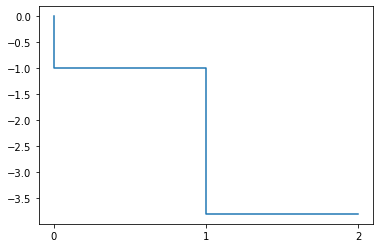

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333
x7,1.666667,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,2.333333
x8,0.666667,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,4.333333
q,2.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,0.000000,1.000000,0.200000,1.200000,1.000000,0.400000,0.200000,0.000000,0.800000
x1,1.000000,0.000000,0.600000,1.600000,2.000000,0.200000,0.600000,0.000000,1.400000
x8,0.000000,0.000000,1.600000,0.600000,-1.000000,0.200000,-0.400000,1.000000,3.400000
q,0.000000,0.000000,-3.200000,-6.200000,-9.000000,-1.400000,-1.200000,0.000000,-3.800000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
x9,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,-3.000000,1.000000
x7,2.000000,0.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,1.000000,2.000000
x8,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000
x2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
q,1.000000,0.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,-3.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,0.000000,0.500000,3.000000,2.500000,1.000000,0.500000,0.000000,-2.500000,2.000000
x1,1.000000,0.000000,0.500000,1.000000,1.500000,0.000000,0.500000,0.000000,0.500000,1.000000
x8,0.000000,0.000000,1.500000,0.000000,-1.500000,0.000000,-0.500000,1.000000,0.500000,3.000000
x2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
q,0.000000,0.000000,-2.500000,-2.000000,-5.500000,0.000000,-0.500000,0.000000,-3.500000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
x9,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.666667,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,0.000000,2.333333
x8,0.666667,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,0.000000,4.333333
x9,-0.333333,0.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,1.000000,-0.666667
q,2.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.200000,1.200000,1.000000,0.400000,0.200000,0.000000,0.000000,0.800000
x1,1.000000,0.000000,0.600000,1.600000,2.000000,0.200000,0.600000,0.000000,0.000000,1.400000
x8,0.000000,0.000000,1.600000,0.600000,-1.000000,0.200000,-0.400000,1.000000,0.000000,3.400000
x9,0.000000,0.000000,0.200000,1.200000,1.000000,0.400000,0.200000,0.000000,1.000000,-0.200000
q,0.000000,0.000000,-3.200000,-6.200000,-9.000000,-1.400000,-1.200000,0.000000,0.000000,-3.800000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.666667,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,0.000000,2.333333
x8,0.666667,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,0.000000,4.333333
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,2.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333,0.666667
x7,0.000000,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,-1.666667,0.666667
x8,0.000000,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,-0.666667,3.666667
x1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,-2.000000,-3.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
x9,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,1.000000,3.000000,-2.000000,-1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.666667,0.000000,1.000000,2.666667,3.333333,0.333333,1.000000,0.000000,0.000000,2.333333
x8,0.666667,0.000000,2.000000,1.666667,0.333333,0.333333,0.000000,1.000000,0.000000,4.333333
x9,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,2.000000,0.000000,-2.000000,-3.000000,-5.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.200000,1.200000,1.000000,0.400000,0.200000,0.000000,0.000000,0.800000
x1,1.000000,0.000000,0.600000,1.600000,2.000000,0.200000,0.600000,0.000000,0.000000,1.400000
x8,0.000000,0.000000,1.600000,0.600000,-1.000000,0.200000,-0.400000,1.000000,0.000000,3.400000
x9,0.000000,0.000000,0.600000,1.600000,2.000000,0.200000,0.600000,0.000000,1.000000,-0.600000
q,0.000000,0.000000,-3.200000,-6.200000,-9.000000,-1.400000,-1.200000,0.000000,0.000000,-3.800000


Simplex method min value: -3.8000000000000003
Branch and bound method min value: -3.0


In [22]:
n, m = 3, 5
A = np.array([[-1, 3, 0, 2, 1],
              [2, -1, 1, 2, 3],
              [1, -1, 2, 1, 0]
             ],
             dtype = 'float'
            )
b = [1, 2, 4]
c = [-1, -3, 2, 1, 4]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,2.500000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,2.666667
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,-5.333333


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,0.000000,1.000000,0.000000,1.125000,1.125000,0.375000,0.250000,-0.125000,0.750000
x1,1.000000,0.000000,0.000000,1.375000,2.375000,0.125000,0.750000,-0.375000,1.250000
x3,0.000000,0.000000,1.000000,0.375000,-0.625000,0.125000,-0.250000,0.625000,2.250000
q,0.000000,0.000000,0.000000,-7.125000,-5.125000,-0.375000,-0.250000,-0.875000,-5.750000


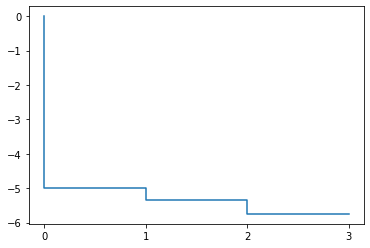

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,2.500000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,2.666667
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,-5.333333


,x1,x2,x3,x4,x5,x6,x7,x8,b
x2,0.000000,1.000000,0.000000,1.125000,1.125000,0.375000,0.250000,-0.125000,0.750000
x1,1.000000,0.000000,0.000000,1.375000,2.375000,0.125000,0.750000,-0.375000,1.250000
x3,0.000000,0.000000,1.000000,0.375000,-0.625000,0.125000,-0.250000,0.625000,2.250000
q,0.000000,0.000000,0.000000,-7.125000,-5.125000,-0.375000,-0.250000,-0.875000,-5.750000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,0.000000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,2.500000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,0.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,0.000000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,0.000000,2.666667
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,0.000000,-5.333333


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.333333,0.666667
x7,0.000000,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,-1.333333,0.333333
x3,0.000000,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,-0.333333,2.333333
x1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,-0.333333,-5.666667


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x10,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,2.000000
x8,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-2.000000,1.000000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,1.000000,-0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-4.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,2.500000,0.000000,3.000000,2.500000,1.000000,0.500000,0.000000,0.000000,-0.500000,2.000000
x1,1.000000,-0.500000,0.000000,1.000000,1.500000,0.000000,0.500000,0.000000,0.000000,-0.500000,1.000000
x8,0.000000,-0.500000,0.000000,0.000000,-1.500000,0.000000,-0.500000,1.000000,0.000000,-1.500000,0.000000
x9,0.000000,0.500000,0.000000,-1.000000,-1.500000,0.000000,-0.500000,0.000000,1.000000,0.500000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,0.000000,0.500000,0.000000,-6.000000,-5.500000,0.000000,-0.500000,0.000000,0.000000,-1.500000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,0.000000,0.000000,8.000000,10.000000,1.000000,3.000000,0.000000,-5.000000,-3.000000,2.000000
x1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x8,0.000000,0.000000,0.000000,-1.000000,-3.000000,0.000000,-1.000000,1.000000,1.000000,-1.000000,0.000000
x2,0.000000,1.000000,0.000000,-2.000000,-3.000000,0.000000,-1.000000,0.000000,2.000000,1.000000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,0.000000,0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,-1.000000,-2.000000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x10,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,0.000000,0.000000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,2.500000
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x10,0.500000,-0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-0.500000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,0.000000,0.000000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,0.000000,0.000000,2.666667
x9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
x10,0.333333,0.000000,0.000000,0.833333,0.166667,0.166667,0.000000,0.500000,0.000000,1.000000,-0.333333
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,0.000000,0.000000,-5.333333


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,1.500000,0.500000,0.500000,0.000000,0.500000,0.000000,1.000000,0.000000
x7,0.000000,0.000000,0.000000,-1.500000,2.500000,-0.500000,1.000000,-2.500000,0.000000,-4.000000,3.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,3.000000
x9,0.000000,0.000000,0.000000,-2.500000,-0.500000,-0.500000,0.000000,-1.500000,1.000000,-3.000000,2.000000
x1,1.000000,0.000000,0.000000,2.500000,0.500000,0.500000,0.000000,1.500000,0.000000,3.000000,-1.000000
q,0.000000,0.000000,0.000000,-7.500000,-4.500000,-0.500000,0.000000,-1.500000,0.000000,-1.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
x9,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,0.000000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,2.500000
x9,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,0.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,0.000000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,0.000000,2.666667
x9,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,0.000000,-5.333333


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,1.125000,1.125000,0.375000,0.250000,-0.125000,0.000000,0.750000
x1,1.000000,0.000000,0.000000,1.375000,2.375000,0.125000,0.750000,-0.375000,0.000000,1.250000
x3,0.000000,0.000000,1.000000,0.375000,-0.625000,0.125000,-0.250000,0.625000,0.000000,2.250000
x9,0.000000,0.000000,0.000000,1.375000,2.375000,0.125000,0.750000,-0.375000,1.000000,-0.750000
q,0.000000,0.000000,0.000000,-7.125000,-5.125000,-0.375000,-0.250000,-0.875000,0.000000,-5.750000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
x9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,-1.000000,2.000000
x8,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.000000,1.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,1.000000,-0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,-2.000000,-4.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,2.500000,0.000000,3.000000,2.500000,1.000000,0.500000,0.000000,-0.500000,2.000000
x1,1.000000,-0.500000,0.000000,1.000000,1.500000,0.000000,0.500000,0.000000,-0.500000,1.000000
x8,0.000000,-0.500000,0.000000,0.000000,-1.500000,0.000000,-0.500000,1.000000,-1.500000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,0.000000,0.500000,0.000000,-6.000000,-5.500000,0.000000,-0.500000,0.000000,-1.500000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,1.200000,1.000000,0.400000,0.200000,0.000000,-0.200000,0.800000
x1,1.000000,0.000000,0.000000,1.600000,2.000000,0.200000,0.600000,0.000000,-0.600000,1.400000
x8,0.000000,0.000000,0.000000,0.600000,-1.000000,0.200000,-0.400000,1.000000,-1.600000,0.400000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
q,0.000000,0.000000,0.000000,-6.600000,-6.000000,-0.200000,-0.600000,0.000000,-1.400000,-5.400000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000
x9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,2.000000
x8,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.000000,0.000000,1.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,-0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,-4.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,2.500000,0.000000,3.000000,2.500000,1.000000,0.500000,0.000000,-0.500000,0.000000,2.000000
x1,1.000000,-0.500000,0.000000,1.000000,1.500000,0.000000,0.500000,0.000000,-0.500000,0.000000,1.000000
x8,0.000000,-0.500000,0.000000,0.000000,-1.500000,0.000000,-0.500000,1.000000,-1.500000,0.000000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,0.000000,0.500000,0.000000,-1.000000,-1.500000,0.000000,-0.500000,0.000000,0.500000,1.000000,0.000000
q,0.000000,0.500000,0.000000,-6.000000,-5.500000,0.000000,-0.500000,0.000000,-1.500000,0.000000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,0.000000,0.000000,8.000000,10.000000,1.000000,3.000000,0.000000,-3.000000,-5.000000,2.000000
x1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
x8,0.000000,0.000000,0.000000,-1.000000,-3.000000,0.000000,-1.000000,1.000000,-1.000000,1.000000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x2,0.000000,1.000000,0.000000,-2.000000,-3.000000,0.000000,-1.000000,0.000000,1.000000,2.000000,0.000000
q,0.000000,0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,-2.000000,-1.000000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000
x9,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,2.000000
x8,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.000000,0.000000,1.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.000000
q,1.000000,-0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,-4.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,0.000000,2.500000,0.000000,3.000000,2.500000,1.000000,0.500000,0.000000,-0.500000,0.000000,2.000000
x1,1.000000,-0.500000,0.000000,1.000000,1.500000,0.000000,0.500000,0.000000,-0.500000,0.000000,1.000000
x8,0.000000,-0.500000,0.000000,0.000000,-1.500000,0.000000,-0.500000,1.000000,-1.500000,0.000000,0.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,0.000000,-0.500000,0.000000,1.000000,1.500000,0.000000,0.500000,0.000000,-0.500000,1.000000,-1.000000
q,0.000000,0.500000,0.000000,-6.000000,-5.500000,0.000000,-0.500000,0.000000,-1.500000,0.000000,-5.000000


,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,1.200000,1.000000,0.400000,0.200000,0.000000,-0.200000,0.000000,0.800000
x1,1.000000,0.000000,0.000000,1.600000,2.000000,0.200000,0.600000,0.000000,-0.600000,0.000000,1.400000
x8,0.000000,0.000000,0.000000,0.600000,-1.000000,0.200000,-0.400000,1.000000,-1.600000,0.000000,0.400000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
x10,0.000000,0.000000,0.000000,1.600000,2.000000,0.200000,0.600000,0.000000,-0.600000,1.000000,-0.600000
q,0.000000,0.000000,0.000000,-6.600000,-6.000000,-0.200000,-0.600000,0.000000,-1.400000,0.000000,-5.400000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,2.000000,-1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,4.000000
x8,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
x9,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.000000
q,1.000000,-0.000000,2.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x6,-1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
x7,1.500000,-0.500000,0.000000,1.500000,3.000000,0.000000,1.000000,-0.500000,0.000000,1.500000
x3,0.500000,-0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,2.500000
x9,0.500000,-0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,1.000000,-0.500000
q,0.000000,1.000000,0.000000,-6.000000,-4.000000,0.000000,0.000000,-1.000000,0.000000,-5.000000


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,-0.333333,1.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333
x7,1.333333,0.000000,0.000000,1.833333,3.166667,0.166667,1.000000,-0.500000,0.000000,1.666667
x3,0.333333,0.000000,1.000000,0.833333,0.166667,0.166667,0.000000,0.500000,0.000000,2.666667
x9,0.333333,0.000000,0.000000,0.833333,0.166667,0.166667,0.000000,0.500000,1.000000,-0.333333
q,0.333333,0.000000,0.000000,-6.666667,-4.333333,-0.333333,0.000000,-1.000000,0.000000,-5.333333


,x1,x2,x3,x4,x5,x6,x7,x8,x9,b
x2,0.000000,1.000000,0.000000,1.500000,0.500000,0.500000,0.000000,0.500000,1.000000,0.000000
x7,0.000000,0.000000,0.000000,-1.500000,2.500000,-0.500000,1.000000,-2.500000,-4.000000,3.000000
x3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,3.000000
x1,1.000000,0.000000,0.000000,2.500000,0.500000,0.500000,0.000000,1.500000,3.000000,-1.000000
q,0.000000,0.000000,0.000000,-7.500000,-4.500000,-0.500000,0.000000,-1.500000,-1.000000,-5.000000


Simplex method min value: -5.75
Branch and bound method min value: -5.0


In [23]:
n, m = 3, 5
A = np.array([[-1, 3, 0, 2, 1],
              [2, -1, 1, 2, 3],
              [1, -1, 2, 1, 0]
             ],
             dtype = 'float'
            )
b = [1, 4, 5]
c = [-1, 0, -2, 5, 4]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,1.000000,-3.000000,2.000000,1.000000,0.000000,1.000000,0.000000,3.000000
x8,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,-1.000000,2.000000,-1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,1.000000,2.500000,0.000000,1.500000,1.000000,1.000000,0.000000,-0.500000,0.500000
x7,5.000000,2.500000,0.000000,3.500000,1.000000,0.000000,1.000000,1.500000,4.500000
x3,1.000000,0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000
q,-1.000000,-2.000000,0.000000,-2.000000,-5.000000,0.000000,0.000000,-1.000000,-1.000000


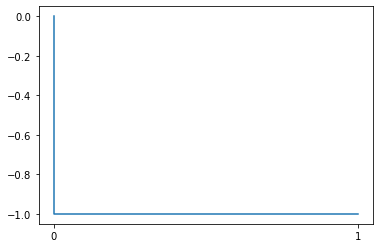

,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
x7,2.000000,1.000000,-3.000000,2.000000,1.000000,0.000000,1.000000,0.000000,3.000000
x8,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
q,1.000000,-1.000000,2.000000,-1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x6,1.000000,2.500000,0.000000,1.500000,1.000000,1.000000,0.000000,-0.500000,0.500000
x7,5.000000,2.500000,0.000000,3.500000,1.000000,0.000000,1.000000,1.500000,4.500000
x3,1.000000,0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000
q,-1.000000,-2.000000,0.000000,-2.000000,-5.000000,0.000000,0.000000,-1.000000,-1.000000


Simplex method min value: -1.0
Branch and bound method min value: -1.0


In [24]:
n, m = 3, 5
A = np.array([[2, 3, 1, 2, 1],
              [2, 1, -3, 2, 1],
              [2, 1, 2, 1, 0]
             ],
             dtype = 'float'
            )
b = [1, 3, 1]
c = [-1, 1, -2, 1, 5]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')

,x1,x2,x3,x4,x5,x6,x7,b
x5,2.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000,2.000000
x6,1.000000,-1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000
x7,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000
q,2.000000,-3.000000,-4.000000,1.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,b
x1,1.000000,0.500000,1.500000,2.000000,0.500000,0.000000,0.000000,1.000000
x6,0.000000,-1.500000,0.500000,-1.000000,-0.500000,1.000000,0.000000,3.000000
x7,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-4.000000,-7.000000,-3.000000,-1.000000,0.000000,0.000000,-2.000000


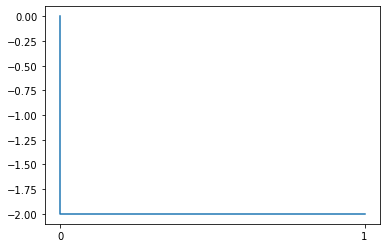

,x1,x2,x3,x4,x5,x6,x7,b
x5,2.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000,2.000000
x6,1.000000,-1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000
x7,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000
q,2.000000,-3.000000,-4.000000,1.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,b
x1,1.000000,0.500000,1.500000,2.000000,0.500000,0.000000,0.000000,1.000000
x6,0.000000,-1.500000,0.500000,-1.000000,-0.500000,1.000000,0.000000,3.000000
x7,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-4.000000,-7.000000,-3.000000,-1.000000,0.000000,0.000000,-2.000000


Simplex method min value: -2.0
Branch and bound method min value: -2.0


In [25]:
n, m = 3, 4
A = np.array([[2, 1, 3, 4],
              [1, -1, 2, 1],
              [0, 0, 1, 3]
             ],
             dtype = 'float'
            )
b = [2, 4, 1]
c = [-2, 3, 4, -1]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')

,x1,x2,x3,x4,x5,x6,x7,b
x5,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,3.000000
x6,2.000000,-1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000
x7,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,2.000000,-1.000000,1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,b
x5,0.000000,1.000000,1.000000,4.000000,1.000000,0.000000,-2.000000,1.000000
x6,0.000000,-3.000000,2.000000,3.000000,0.000000,1.000000,-2.000000,2.000000
x1,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-3.000000,1.000000,-1.000000,0.000000,0.000000,-2.000000,-2.000000


,x1,x2,x3,x4,x5,x6,x7,b
x3,0.000000,1.000000,1.000000,4.000000,1.000000,0.000000,-2.000000,1.000000
x6,0.000000,-5.000000,0.000000,-5.000000,-2.000000,1.000000,2.000000,0.000000
x1,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-4.000000,0.000000,-5.000000,-1.000000,0.000000,0.000000,-3.000000


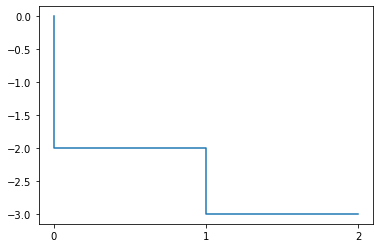

,x1,x2,x3,x4,x5,x6,x7,b
x5,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,3.000000
x6,2.000000,-1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000
x7,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,2.000000,-1.000000,1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,b
x5,0.000000,1.000000,1.000000,4.000000,1.000000,0.000000,-2.000000,1.000000
x6,0.000000,-3.000000,2.000000,3.000000,0.000000,1.000000,-2.000000,2.000000
x1,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-3.000000,1.000000,-1.000000,0.000000,0.000000,-2.000000,-2.000000


,x1,x2,x3,x4,x5,x6,x7,b
x3,0.000000,1.000000,1.000000,4.000000,1.000000,0.000000,-2.000000,1.000000
x6,0.000000,-5.000000,0.000000,-5.000000,-2.000000,1.000000,2.000000,0.000000
x1,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
q,0.000000,-4.000000,0.000000,-5.000000,-1.000000,0.000000,0.000000,-3.000000


Simplex method min value: -3.0
Branch and bound method min value: -3.0


In [26]:
n, m = 3, 4
A = np.array([[2, 3, 1, 2],
              [2, -1, 2, 1],
              [1, 1, 0, -1]
             ],
             dtype = 'float'
            )
b = [3, 4, 1]
c = [-2, 1, -1, 3]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')

,x1,x2,x3,x4,x5,x6,x7,x8,b
x7,1.000000,2.000000,3.000000,1.000000,2.000000,5.000000,1.000000,0.000000,1.000000
x8,2.000000,-3.000000,1.000000,2.000000,1.000000,4.000000,0.000000,1.000000,2.000000
q,2.000000,-3.000000,-4.000000,1.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x1,1.000000,2.000000,3.000000,1.000000,2.000000,5.000000,1.000000,0.000000,1.000000
x8,0.000000,-7.000000,-5.000000,0.000000,-3.000000,-6.000000,-2.000000,1.000000,0.000000
q,0.000000,-7.000000,-10.000000,-1.000000,-6.000000,-11.000000,-2.000000,0.000000,-2.000000


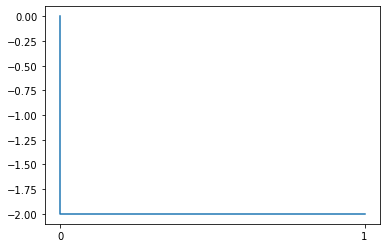

,x1,x2,x3,x4,x5,x6,x7,x8,b
x7,1.000000,2.000000,3.000000,1.000000,2.000000,5.000000,1.000000,0.000000,1.000000
x8,2.000000,-3.000000,1.000000,2.000000,1.000000,4.000000,0.000000,1.000000,2.000000
q,2.000000,-3.000000,-4.000000,1.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000


,x1,x2,x3,x4,x5,x6,x7,x8,b
x1,1.000000,2.000000,3.000000,1.000000,2.000000,5.000000,1.000000,0.000000,1.000000
x8,0.000000,-7.000000,-5.000000,0.000000,-3.000000,-6.000000,-2.000000,1.000000,0.000000
q,0.000000,-7.000000,-10.000000,-1.000000,-6.000000,-11.000000,-2.000000,0.000000,-2.000000


Simplex method min value: -2.0
Branch and bound method min value: -2.0


In [27]:
n, m = 2, 6
A = np.array([[1, 2, 3, 1, 2, 5],
              [2, -3, 1, 2, 1, 4]
             ],
             dtype = 'float'
            )
b = [1, 2]
c = [-2, 3, 4, -1, 2, 1]
smx_min_q = main_simplex(n, m, A, b, c)
bb_min_q = branch_bound(n, m, A, b, c)
print(f'Simplex method min value: {smx_min_q}')
print(f'Branch and bound method min value: {bb_min_q}')